# Uncertainty Calibration（不确定性校准）

> 本 notebook 针对 `results/feature_error_std.txt` 中的样本级别 (error_x, error_y, std) 做 **uncertainty calibration**。

我们关心的问题是：模型给出的不确定性/标准差 `std` 是否与真实误差的分布一致？如果一致，那么：
- 预测的区间/置信区域应该拥有正确的覆盖率（coverage）。
- 归一化残差（例如 $z = \frac{e}{\sigma}$）在统计上应接近理论分布（Gaussian / Rayleigh / Chi 分布）。

下面给出两类常用校准方法，并结合二维误差（x/y）与“瑞雷分布”讨论分位值与覆盖率的正确计算方式。

## 0. 数据与“std”的含义（需要先澄清）

文件包含列：`error_x, error_y, px, py, density, intensity, std`。这里的 `std` 是你统计得到的标准差（或模型预测的 scale）。它可能对应：

- **(A) 每个样本的同一个标量 σ**：假设 $e_x \sim \mathcal{N}(0,\sigma^2),\ e_y \sim \mathcal{N}(0,\sigma^2)$（各向同性、同方差），并且 `std` 就是该样本的 σ。
- **(B) 每个样本每轴一套 σ_x/σ_y**：但当前文件只有一个 `std`，所以更像 (A)。
- **(C) “分箱统计 std”**：即你先按某类特征（distance/intensity/density）聚类/分箱，再对 bin 内的误差求 std，把这个 std 再回填到 bin 内所有样本。此时 `std` 是“组统计量”，不是模型的 per-sample predictive std。

本 notebook 会用以下诊断来验证 `error` 和 `std` 是否“匹配”：
- 归一化残差 $z_x=e_x/\sigma$、$z_y=e_y/\sigma$ 是否近似稳定（均值≈0、方差≈1）。
- 二维误差幅值 $r=\sqrt{e_x^2+e_y^2}$ 的归一化 $z_r=r/\sigma$ 是否接近 Rayleigh/Chi 分布形状。

## 1) 校准目标：coverage/quantile 与 reliability 的统一视角

假设你给每个样本一个预测分布 $p(e\mid\sigma)$（或参数化分布 $p_\theta$），校准的核心就是：

$$\Pr\big(e \in \mathcal{R}_\alpha(\sigma)\big) = \alpha,\ \ \forall\alpha\in(0,1)$$

其中 $\mathcal{R}_\alpha(\sigma)$ 是“理论上应该覆盖 $\alpha$ 概率质量的集合”。

典型选择：

### 1.1 一维（每轴）Gaussian 的 coverage

若 $e_x\sim\mathcal{N}(0,\sigma^2)$，那么区间 $[-k\sigma,\ k\sigma]$ 的覆盖率为：

$$\alpha(k)=\Pr(|e_x|\le k\sigma)=2\Phi(k)-1$$

因此给定目标覆盖率 $\alpha$，对应 $k=\Phi^{-1}\big((1+\alpha)/2\big)$。

### 1.2 二维各向同性 Gaussian → 半径 r 的 Rayleigh（你提到的关键点）

如果 $(e_x,e_y)$ 独立且同方差：

$$e_x,e_y\overset{i.i.d.}{\sim}\mathcal{N}(0,\sigma^2)$$

那么半径 $r=\sqrt{e_x^2+e_y^2}$ 服从 **Rayleigh** 分布（也可看作 scaled Chi 分布，2 个自由度）：

$$\frac{r}{\sigma} \sim \text{Rayleigh}(1),\ \ f(z)=z\exp(-z^2/2),\ z\ge 0$$

其 CDF：

$$\Pr(r\le t)=1-\exp\left(-\frac{t^2}{2\sigma^2}\right)$$

因此要构造“应覆盖 $\alpha$ 的圆形置信区域”（radius 版本）：

$$t_\alpha(\sigma)=\sigma\sqrt{-2\ln(1-\alpha)}$$

这就是你提醒的点：**两个正态分量的 RMS/半径不再是正态**，用一维分位值会算错 coverage。

### 1.3 椭圆区域（更一般：协方差 Σ）

若 $e\sim\mathcal{N}(0,\Sigma)$，则马氏距离：

$$m^2=e^T\Sigma^{-1}e \sim \chi^2_{d}$$

二维下 $d=2$，所以 $\alpha$ 覆盖的椭圆区域满足 $m^2\le \chi^2_{2}(\alpha)$。

当前数据只有一个 `std`，我们默认先做各向同性圆形区域（Rayleigh），并额外提供“逐轴Gaussian”的对照。

## 2) 两种实做的校准评估/校准方式

### 方法 A：Coverage / Quantile calibration（连续 α 曲线）

核心思路：对一系列 $\alpha\in(0,1)$，比较
- 经验覆盖率（empirical coverage）：$\hat c(\alpha)=\frac{1}{N}\sum_i \mathbf{1}\{e_i\in\mathcal{R}_\alpha(\sigma_i)\}$
- 理论覆盖率：$c(\alpha)=\alpha$

然后绘制 reliability curve：$\hat c(\alpha)$ vs $\alpha$。常用摘要指标：
- **ACE**：$\int_0^1 |\hat c(\alpha)-\alpha|d\alpha$（离散近似）
- 或者在若干 anchor points（例如 0.5/0.8/0.9/0.95）上报告误差。

特点：不需要分箱；直接验证“你给的分布形状/scale 是否对”。

### 方法 B：按预测不确定性分箱（binning reliability diagram）

把样本按 `std`（或任意 uncertainty proxy）排序并分到 $B$ 个 bin（通常用 equal-count 更稳），每个 bin 内再比较：
- 预测的典型尺度（例如 $\bar\sigma_b$ 或 median(σ)）
- 真实误差的尺度（例如 $\text{RMSE}(e)$，或 $\text{median}(|e|)$ / $q_{\alpha}(|e|)$）

如果是二维幅值 $r$，则比较 $q_\alpha(r)$ 与 $t_\alpha(\sigma)$ 更合理。

这种方法特别适合你提到的情况 (C)：**如果 `std` 本身就是分箱统计量**，那 binning 反而更“同源”。

## 3) 文献/参考（校准思想来源）

这里给几类与你的需求最贴近的参考（不局限于分类 ECE，而是“连续变量/回归不确定性”）：

- **Kuleshov et al., 2018**：*Accurate Uncertainties for Deep Learning Using Calibrated Regression*（回归分位值/coverage 校准的经典工作，提出用校准映射让预测分布满足 coverage）。
- **Gneiting & Raftery, 2007**：*Strictly Proper Scoring Rules, Prediction, and Estimation*（概率预测的正确评估：NLL/CRPS 等；解释为何 coverage 与 proper scoring 相关但不等价）。
- **Levi et al., 2022 / various**（不确定性可靠性图、回归 ECE/ACE 的实践文章很多；我们在实现里采用通用 reliability curve 思路，不依赖特定网络结构）。
- **Rayleigh/Chi 分布**：任何统计教材/分布手册都可作为依据：二维 i.i.d Gaussian 的半径服从 Rayleigh；一般 $\chi^2$ 与马氏距离用于椭圆置信区域。

## 4) 本 notebook 中将做什么

1. 读取数据并验证 `std` 与 error 的关系（包括 $z_x,z_y,z_r$ 的分布形状）。
2. 实现两种 calibration 评估：
   - 方法 A：coverage curve（逐轴 Gaussian 与 二维 Rayleigh 两个版本）。
   - 方法 B：按 `std` 分箱的可靠性图（同样给逐轴/半径两个版本）。
3. 可选：给出一个简单的“scale recalibration”映射（例如学习 $\hat\sigma' = a\sigma$ 或 isotonic regression），观察校准改善（保持风险较低、易解释）。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

DATA_PATH = "results/feature_error_std.txt"

# The file uses tabs AND extra tab padding, so read with regex separator and drop empty columns.
df_raw = pd.read_csv(DATA_PATH, sep=r"\t+", engine="python")
df_raw.columns = [c.strip() for c in df_raw.columns]
df = df_raw.loc[:, ~df_raw.columns.str.contains(r"^Unnamed")].copy()

# Ensure numeric dtype
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())

# Backward/forward compatibility: require these columns
required = ["error_x", "error_y"]
for r in required:
    if r not in df.columns:
        raise ValueError(f"Missing required column: {r}")

# New columns after stdExtract.ipynb update
for name in ["std", "std_x", "std_y", "std_r"]:
    if name in df.columns:
        print(f"{name}: mean={df[name].mean():.4f}, std={df[name].std():.4f}, min={df[name].min():.4f}, max={df[name].max():.4f}")
    else:
        print(f"WARNING: column {name} not found")

df.head()

Loaded shape: (21025, 10)
Columns: ['error_x', 'error_y', 'px', 'py', 'density', 'intensity', 'std', 'std_x', 'std_y', 'std_r']
std: mean=0.1501, std=0.0621, min=0.0530, max=0.4350
std_x: mean=0.1199, std=0.0537, min=0.0370, max=0.3670
std_y: mean=0.0862, std=0.0411, min=0.0200, max=0.2810
std_r: mean=0.0918, std=0.0401, min=0.0270, max=0.3290


,error_x,error_y,px,py,density,intensity,std,std_x,std_y,std_r
0,0.253,-0.048,34.38,-3.18,8.648,0.123,0.155,0.141,0.065,0.075
1,0.135,0.036,13.22,-1.00,59.973,0.131,0.080,0.063,0.049,0.050
2,-0.004,-0.018,38.26,15.71,7.227,0.021,0.220,0.168,0.142,0.127
3,-0.100,0.161,31.73,2.61,4.733,0.083,0.214,0.151,0.151,0.117
4,-0.145,0.289,19.72,12.54,39.031,0.069,0.170,0.116,0.124,0.097


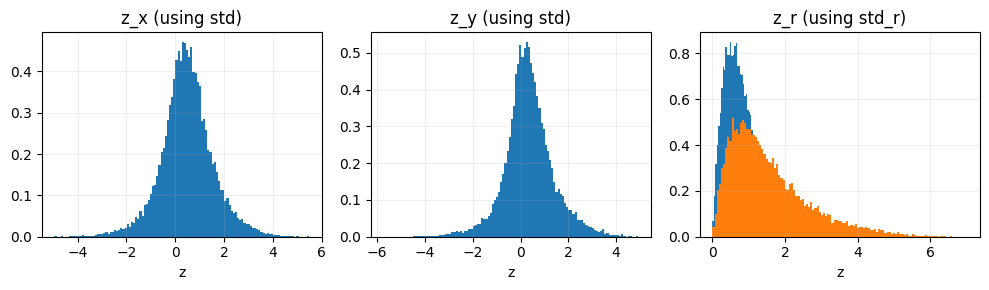

In [3]:
# Basic sanity checks: missing values and some quick relationships
# print(df.isna().mean().sort_values(ascending=False).head(15))
# print(df.describe())

# Construct derived error magnitudes
df["err_abs_x"] = df["error_x"].abs()
df["err_abs_y"] = df["error_y"].abs()
df["err_r"] = np.sqrt(df["error_x"]**2 + df["error_y"]**2)

# Normalized residual diagnostics: compare using std (combined RMS) vs std_r (radial std)
df["z_x_std"] = df["error_x"] / df["std_x"]
df["z_y_std"] = df["error_y"] / df["std_y"]
df["z_r_std"] = df["err_r"] / df["std"]
df["z_r_stdr"] = df["err_r"] / df["std_r"]

# Visualize z distributions side-by-side
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex='col')

def hist_on(a, data, title, clip):
    v = data.replace([np.inf, -np.inf], np.nan).dropna().clip(*clip)
    a.hist(v, bins=120, density=True)
    a.set_title(title)
    a.grid(True, alpha=0.2)

hist_on(ax[0], df["z_x_std"], "z_x (using std)", (-10, 10))
hist_on(ax[1], df["z_y_std"], "z_y (using std)", (-10, 10))
hist_on(ax[2], df["z_r_std"], "z_r (using std)", (0, 10))
hist_on(ax[2], df["z_r_stdr"], "z_r (using std_r)", (0, 10))

for j in range(3):
    ax[j].set_xlabel("z")
plt.tight_layout()
plt.show()

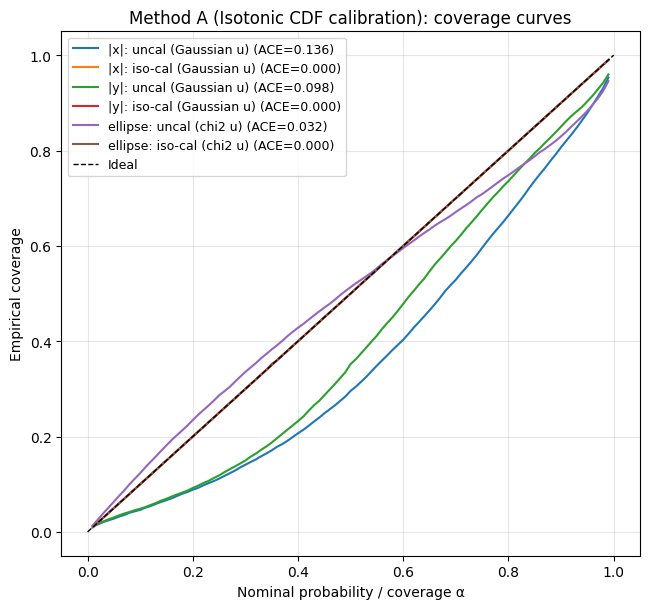

In [4]:
# -----------------------------
# Method A (paper-style): Isotonic CDF calibration (Kuleshov-style)
# -----------------------------
# Goal: learn a monotone map R:[0,1]->[0,1] so that calibrated CDF
#   F_cal(y) = R(F(y))
# satisfies  P(Y <= F_cal^{-1}(p)) = p  (coverage / probability integral transform).
#
# We implement for:
#  (1) 1D per-axis Gaussian: e ~ N(0, sigma^2) -> u = F(e).
#  (2) 2D ellipse (RMS-style, chi-square): m^2=(ex/sx)^2+(ey/sy)^2 ~ Chi2(df=2).
#      Use u = CDF_Chi2(m^2).
#
# Notes:
# - This method uses coverage/probability directly. It does NOT re-fit sigma;
#   it calibrates the probability scale, then you can map desired nominal alpha to an
#   empirical one via R^{-1} when building regions.
# - We fit isotonic regression on (u_t, P_hat(u_t)) with y increasing, as in your method.md.


from sklearn.isotonic import IsotonicRegression

def ace_metric(alphas: np.ndarray, emp_cov: np.ndarray) -> float:
    return float(np.mean(np.abs(np.asarray(emp_cov) - np.asarray(alphas))))

def fit_isotonic_map(u: np.ndarray):
    """Fit monotone R such that R(u) approximates empirical CDF of u.

    Input:
      u: array in [0,1], usually u_t = F_t(y_t). For perfect calibration u is Uniform(0,1).

    Returns:
      iso: fitted IsotonicRegression
      u_sorted, p_hat_sorted: training curve points (for inspection/plotting)
    """
    u = np.asarray(u)
    u = u[np.isfinite(u)]
    u = np.clip(u, 0.0, 1.0)
    if len(u) < 20:
        raise ValueError("Not enough calibration samples to fit isotonic map.")

    order = np.argsort(u)
    u_sorted = u[order]
    # empirical CDF value at each u_sorted[t] (1..T)/T
    T = len(u_sorted)
    p_hat_sorted = (np.arange(1, T + 1, dtype=float) / T)

    iso = IsotonicRegression(y_min=0.0, y_max=1.0, increasing=True, out_of_bounds="clip")
    iso.fit(u_sorted, p_hat_sorted)
    return iso, u_sorted, p_hat_sorted

def apply_isotonic_cdf(iso: IsotonicRegression, u: np.ndarray) -> np.ndarray:
    u = np.asarray(u)
    valid = np.isfinite(u)
    out = np.full_like(u, np.nan, dtype=float)
    uu = np.clip(u[valid], 0.0, 1.0)
    out[valid] = iso.predict(uu)
    return out

def invert_isotonic(iso: IsotonicRegression, p: np.ndarray, n_grid: int = 4096) -> np.ndarray:
    """Approximate inverse of monotone iso map via dense grid search.

    We need R^{-1}(alpha) to convert nominal coverage alpha to a pre-calibration
    probability level u so that R(u) = alpha.
    """
    p = np.asarray(p)
    grid_u = np.linspace(0.0, 1.0, n_grid)
    grid_r = iso.predict(grid_u)
    # ensure monotone non-decreasing; isotonic should already guarantee it, but numeric safety
    grid_r = np.maximum.accumulate(grid_r)
    return np.interp(np.clip(p, 0.0, 1.0), grid_r, grid_u)

# --------- u_t constructions ---------
def u_gaussian_1d(errors: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    errors = np.asarray(errors)
    sigma = np.asarray(sigma)
    valid = np.isfinite(errors) & np.isfinite(sigma) & (sigma > 0)
    z = errors[valid] / sigma[valid]
    u = stats.norm.cdf(z)
    return np.clip(u, 0.0, 1.0)

def u_chi2_ellipse(err_x: np.ndarray, err_y: np.ndarray, sigma_x: np.ndarray, sigma_y: np.ndarray) -> np.ndarray:
    err_x = np.asarray(err_x)
    err_y = np.asarray(err_y)
    sigma_x = np.asarray(sigma_x)
    sigma_y = np.asarray(sigma_y)
    valid = (np.isfinite(err_x) & np.isfinite(err_y) & np.isfinite(sigma_x) & np.isfinite(sigma_y) & (sigma_x > 0) & (sigma_y > 0))
    m2 = (err_x[valid] / sigma_x[valid]) ** 2 + (err_y[valid] / sigma_y[valid]) ** 2
    u = stats.chi2.cdf(m2, df=2)
    return np.clip(u, 0.0, 1.0)

# --------- coverage curves with isotonic calibration ---------
def coverage_curve_uncalibrated_u(u: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """Empirical coverage for event {u <= alpha} (should equal alpha if calibrated)."""
    u = np.asarray(u)
    alphas = np.asarray(alphas)
    u = u[np.isfinite(u)]
    u = np.clip(u, 0.0, 1.0)
    return np.array([(u <= a).mean() for a in alphas], dtype=float)

def coverage_curve_calibrated_u(iso: IsotonicRegression, u: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """Coverage after calibration: for target alpha, use u_thr=R^{-1}(alpha), then test u<=u_thr."""
    u = np.asarray(u)
    alphas = np.asarray(alphas)
    u = u[np.isfinite(u)]
    u = np.clip(u, 0.0, 1.0)
    u_thr = invert_isotonic(iso, alphas)
    return np.array([(u <= t).mean() for t in u_thr], dtype=float)

def coverage_curve_1d(errors: np.ndarray, sigma: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """Compute empirical coverage for |errors| under N(0,sigma^2) at given alphas."""
    u_t = u_gaussian_1d(errors, sigma)
    return coverage_curve_uncalibrated_u(u_t, alphas)

def coverage_curve_ellipse(err_x: np.ndarray, err_y: np.ndarray, sigma_x: np.ndarray, sigma_y: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """Compute empirical coverage for ellipse errors under Chi2(2) at given alphas."""
    u_t = u_chi2_ellipse(err_x, err_y, sigma_x, sigma_y)
    return coverage_curve_uncalibrated_u(u_t, alphas)

# --------- Fit isotonic maps on the real dataset df ---------
alphas = np.linspace(0.01, 0.99, 99)

iso_maps = {}
curves = {}

if "std_x" in df.columns:
    u_x = u_gaussian_1d(df["error_x"].to_numpy(), df["std_x"].to_numpy())
    iso_x, ux_sorted, px_hat = fit_isotonic_map(u_x)
    iso_maps["x"] = iso_x
    curves["|x|: uncal (Gaussian u)"] = coverage_curve_uncalibrated_u(u_x, alphas)
    curves["|x|: iso-cal (Gaussian u)"] = coverage_curve_calibrated_u(iso_x, u_x, alphas)

if "std_y" in df.columns:
    u_y = u_gaussian_1d(df["error_y"].to_numpy(), df["std_y"].to_numpy())
    iso_y, uy_sorted, py_hat = fit_isotonic_map(u_y)
    iso_maps["y"] = iso_y
    curves["|y|: uncal (Gaussian u)"] = coverage_curve_uncalibrated_u(u_y, alphas)
    curves["|y|: iso-cal (Gaussian u)"] = coverage_curve_calibrated_u(iso_y, u_y, alphas)

if "std_x" in df.columns and "std_y" in df.columns:
    u_e = u_chi2_ellipse(df["error_x"].to_numpy(), df["error_y"].to_numpy(), df["std_x"].to_numpy(), df["std_y"].to_numpy())
    iso_e, ue_sorted, pe_hat = fit_isotonic_map(u_e)
    iso_maps["ellipse"] = iso_e
    curves["ellipse: uncal (chi2 u)"] = coverage_curve_uncalibrated_u(u_e, alphas)
    curves["ellipse: iso-cal (chi2 u)"] = coverage_curve_calibrated_u(iso_e, u_e, alphas)

plt.figure(figsize=(6.6, 6.2))
for name, emp in curves.items():
    ace = ace_metric(alphas, emp)
    plt.plot(alphas, emp, label=f"{name} (ACE={ace:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Ideal")
plt.xlabel("Nominal probability / coverage α")
plt.ylabel("Empirical coverage")
plt.title("Method A (Isotonic CDF calibration): coverage curves")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

alpha_bin=0.9, n_bins=20
r using std | mean relative gap: 0.08477973954657392
x using std_x | mean relative gap: 0.153110782295866
y using std_y | mean relative gap: 0.10647212234224583


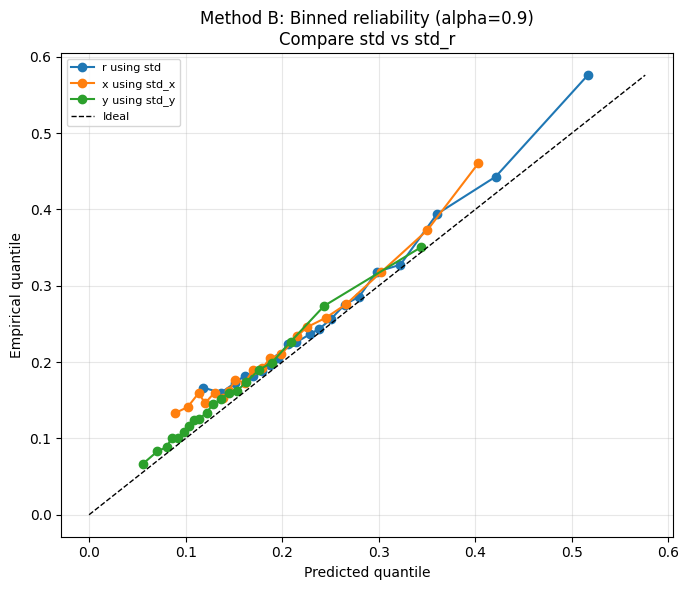

In [5]:
# -----------------------------
# Method B: Binning by uncertainty (reliability diagram)
# Compare std vs std_r (and optionally ellipse with std_x/std_y)
# -----------------------------
def make_bins_equal_count(values: np.ndarray, n_bins: int):
    values = np.asarray(values)
    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(values, qs)
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = edges[i-1] + 1e-12
    return edges

def bin_stats(values: np.ndarray, bins: np.ndarray):
    idx = np.digitize(values, bins, right=False) - 1
    valid = (idx >= 0) & (idx < (len(bins) - 1))
    return idx, valid

def binned_reliability_1d(errors: np.ndarray, sigma: np.ndarray, n_bins: int = 20, alpha: float = 0.9):
    """Compare empirical q_alpha(|e|) with HalfNormal predicted q under N(0,sigma^2)."""
    errors = np.asarray(errors)
    sigma = np.asarray(sigma)
    valid0 = np.isfinite(errors) & np.isfinite(sigma) & (sigma > 0)
    e = np.abs(errors[valid0])
    s = sigma[valid0]
    bins = make_bins_equal_count(s, n_bins)
    idx, valid = bin_stats(s, bins)
    e, s, idx = e[valid], s[valid], idx[valid]
    out = []
    for b in range(n_bins):
        m = idx == b
        if m.sum() < 20:
            continue
        s_med = np.median(s[m])
        emp_q = np.quantile(e[m], alpha)
        pred_q = stats.halfnorm.ppf(alpha, scale=s_med)
        out.append((b, m.sum(), s_med, emp_q, pred_q))
    return pd.DataFrame(out, columns=["bin", "n", "sigma_med", "emp_q", "pred_q"])

def binned_empirical_std_r(err_x: np.ndarray, err_y: np.ndarray, sigma_x: np.ndarray, sigma_y: np.ndarray, n_bins: int = 20, min_count: int = 30):
    """Estimate empirical std_r in bins of combined sigma_r = sqrt(sigma_x^2 + sigma_y^2)."""
    valid0 = (np.isfinite(err_x) & np.isfinite(err_y) & np.isfinite(sigma_x) & np.isfinite(sigma_y) & (sigma_x > 0) & (sigma_y > 0))
    ex = err_x[valid0]
    ey = err_y[valid0]
    sr = np.sqrt(sigma_x[valid0] ** 2 + sigma_y[valid0] ** 2)
    er = np.sqrt(ex ** 2 + ey ** 2)
    bins = make_bins_equal_count(sr, n_bins)
    idx, valid = bin_stats(sr, bins)
    er, sr, idx = er[valid], sr[valid], idx[valid]
    out = []
    for b in range(n_bins):
        m = idx == b
        if m.sum() < min_count:
            continue
        s_med = np.median(sr[m])
        emp_std_r = np.sqrt(np.mean(er[m] ** 2))
        pred_std_r = s_med
        out.append((b, m.sum(), s_med, emp_std_r, pred_std_r))
    return pd.DataFrame(out, columns=["bin", "n", "sigma_med", "emp_q", "pred_q"])

def summarize_rel_gap(bdf: pd.DataFrame):
    return float(np.mean(np.abs(bdf["emp_q"] - bdf["pred_q"]) / (bdf["pred_q"] + 1e-12)))

alpha_bin = 0.9
n_bins = 20

plots = []

plots.append(("r using std", binned_reliability_1d(df["err_r"], df["std"], n_bins=n_bins, alpha=alpha_bin)))
plots.append(("x using std_x", binned_reliability_1d(df["err_abs_x"], df["std_x"], n_bins=n_bins, alpha=alpha_bin)))
plots.append(("y using std_y", binned_reliability_1d(df["err_abs_y"], df["std_y"], n_bins=n_bins, alpha=alpha_bin)))

print(f"alpha_bin={alpha_bin}, n_bins={n_bins}")
for name, bdf in plots:
    print(name, "| mean relative gap:", summarize_rel_gap(bdf))

plt.figure(figsize=(7, 6))
for name, bdf in plots:
    plt.plot(bdf["pred_q"], bdf["emp_q"], "o-", label=name)

mx = max([bdf[["pred_q", "emp_q"]].to_numpy().max() for _, bdf in plots]) if plots else 1.0
plt.plot([0, mx], [0, mx], "k--", lw=1, label="Ideal")
plt.xlabel("Predicted quantile")
plt.ylabel("Empirical quantile")
plt.title(f"Method B: Binned reliability (alpha={alpha_bin})\nCompare std vs std_r")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

Sampled df_syn: (2000, 17)
bias_x stats:
 count    2000.000000
mean        1.183878
std         0.092630
min         1.000000
25%         1.124194
50%         1.200350
75%         1.260961
max         1.300000
bias_y stats:
 count    2000.000000
mean        1.147103
std         0.074104
min         1.000000
25%         1.099356
50%         1.160280
75%         1.208769
max         1.240000
corr(dist, std_x_biased)=0.754
corr(dist, std_y_biased)=0.735
z_x: mean=-0.019, std=0.990
z_y: mean=0.044, std=0.998


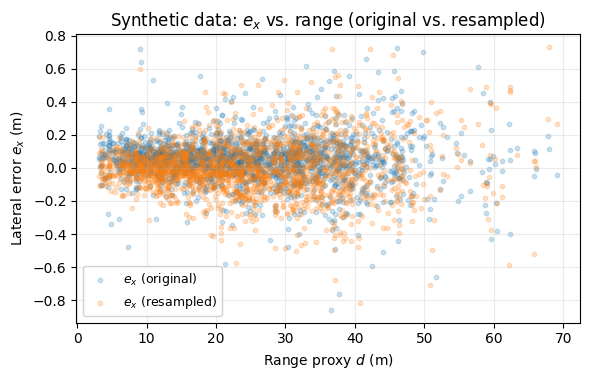

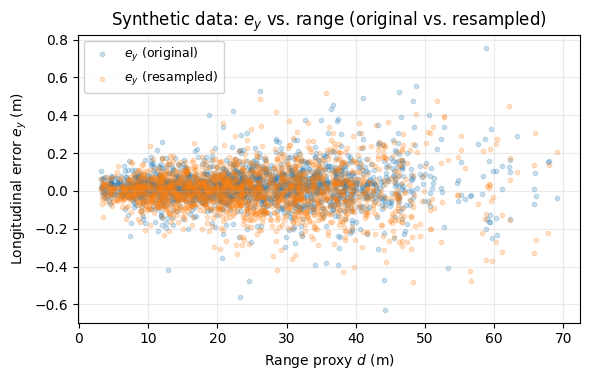

In [6]:
# =============================
# Synthetic test data generation (per-axis)
# =============================

# Updated requirement: after biasing std_x/std_y, also RESAMPLE synthetic errors from the biased sigmas.
# This makes a clean controlled synthetic dataset where (error, sigma) are statistically consistent by construction.
# We'll keep the original sampled errors in *_orig columns for reference.

seed = 14
rng = np.random.default_rng(seed)  # fixed seed
n_syn = 2000
df_src = df.copy()
df_syn = df_src.sample(n=min(n_syn, len(df_src)), replace=False, random_state=seed).reset_index(drop=True)
print("Sampled df_syn:", df_syn.shape)

# Keep original errors for reference, then overwrite error_x/error_y with synthetic draws
df_syn["error_x_orig"] = df_syn["error_x"].to_numpy()
df_syn["error_y_orig"] = df_syn["error_y"].to_numpy()

# Distance proxy (meters)
df_syn["dist"] = np.sqrt(df_syn["px"]**2 + df_syn["py"]**2)

# Smooth ramp in [0,1] based on distance percentiles: close ~0, far ~1.
q_lo, q_hi = df_syn["dist"].quantile([0.10, 0.90]).to_numpy()
ramp = (df_syn["dist"] - q_lo) / (q_hi - q_lo + 1e-12)
ramp = np.clip(ramp, 0.0, 1.0)

# Make the gain larger in the early part: use concave transform on ramp.
# - sqrt(ramp) boosts the "front half" (e.g., ramp=0.25 -> 0.5).
ramp_gain = np.sqrt(ramp)

# Bias strengths: keep moderate but slightly stronger than before.
# (Farther -> larger uncertainty, but make near/mid distances already show some increase.)
max_gain_x = 0.30
max_gain_y = 0.24
df_syn["bias_x"] = 1.0 + max_gain_x * ramp_gain
df_syn["bias_y"] = 1.0 + max_gain_y * ramp_gain
print("bias_x stats:\n", df_syn["bias_x"].describe().to_string())
print("bias_y stats:\n", df_syn["bias_y"].describe().to_string())

# Construct biased per-axis uncertainties
if "std_x" not in df_syn.columns or "std_y" not in df_syn.columns:
    raise ValueError("This workflow requires std_x and std_y columns in the dataset.")
df_syn["std_x_biased"] = df_syn["std_x"] * df_syn["bias_x"]
df_syn["std_y_biased"] = df_syn["std_y"] * df_syn["bias_y"]

# Resample synthetic errors consistent with biased sigmas (Gaussian per axis)
df_syn["error_x"] = rng.normal(loc=0.0, scale=df_syn["std_x_biased"].to_numpy(), size=len(df_syn))
df_syn["error_y"] = rng.normal(loc=0.0, scale=df_syn["std_y_biased"].to_numpy(), size=len(df_syn))
df_syn["err_abs_x"] = np.abs(df_syn["error_x"])
df_syn["err_abs_y"] = np.abs(df_syn["error_y"])

# Derived overall scalar ONLY for plotting (as requested)
df_syn["std_xy_orig"] = np.sqrt(df_syn["std_x"]**2 + df_syn["std_y"]**2)
df_syn["std_xy_biased"] = np.sqrt(df_syn["std_x_biased"]**2 + df_syn["std_y_biased"]**2)

# Sanity check: (1) bias increases with distance
corr_x = np.corrcoef(df_syn["dist"].to_numpy(), df_syn["std_x_biased"].to_numpy())[0, 1]
corr_y = np.corrcoef(df_syn["dist"].to_numpy(), df_syn["std_y_biased"].to_numpy())[0, 1]
print(f"corr(dist, std_x_biased)={corr_x:.3f}")
print(f"corr(dist, std_y_biased)={corr_y:.3f}")

# Sanity check: (2) errors match scales in aggregate (should be ~1)
zxs = df_syn["error_x"].to_numpy() / (df_syn["std_x_biased"].to_numpy() + 1e-12)
zys = df_syn["error_y"].to_numpy() / (df_syn["std_y_biased"].to_numpy() + 1e-12)
print(f"z_x: mean={zxs.mean():.3f}, std={zxs.std():.3f}")
print(f"z_y: mean={zys.mean():.3f}, std={zys.std():.3f}")

# -----------------------------
# Plot: original vs resampled errors (academic-style captions)
# -----------------------------
plt.figure(figsize=(6, 3.9))
plt.scatter(df_syn["dist"], df_syn["error_x_orig"], s=10, alpha=0.22, label=r"$e_x$ (original)")
plt.scatter(df_syn["dist"], df_syn["error_x"], s=10, alpha=0.22, label=r"$e_x$ (resampled)")
plt.xlabel(r"Range proxy $d$ (m)")
plt.ylabel(r"Lateral error $e_x$ (m)")
plt.title(r"Synthetic data: $e_x$ vs. range (original vs. resampled)")
plt.grid(True, alpha=0.25)
plt.legend(fontsize=9, frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3.9))
plt.scatter(df_syn["dist"], df_syn["error_y_orig"], s=10, alpha=0.22, label=r"$e_y$ (original)")
plt.scatter(df_syn["dist"], df_syn["error_y"], s=10, alpha=0.22, label=r"$e_y$ (resampled)")
plt.xlabel(r"Range proxy $d$ (m)")
plt.ylabel(r"Longitudinal error $e_y$ (m)")
plt.title(r"Synthetic data: $e_y$ vs. range (original vs. resampled)")
plt.grid(True, alpha=0.25)
plt.legend(fontsize=9, frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()

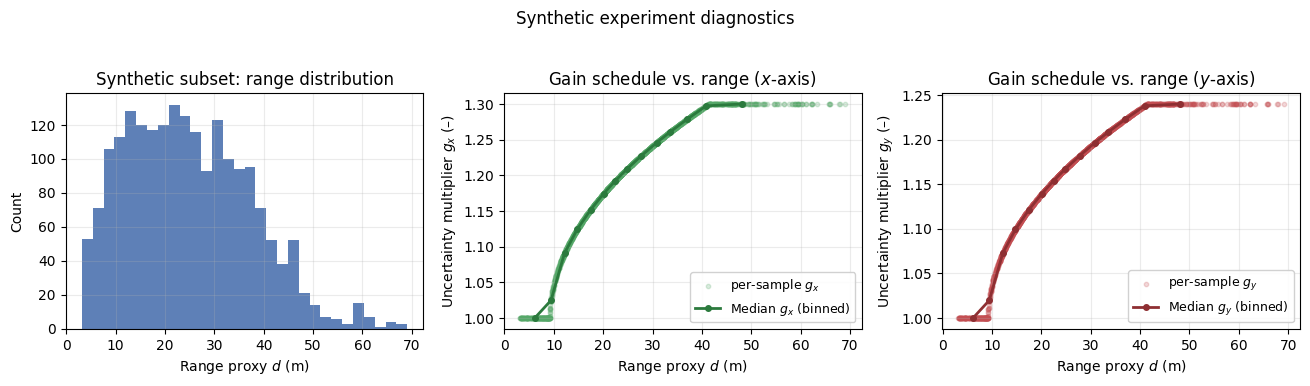

In [7]:
# ==========================================
# Diagnostic plots: sampling distribution & gain schedule
# ==========================================

dist = df_syn["dist"].to_numpy()
bias_x = df_syn["bias_x"].to_numpy()
bias_y = df_syn["bias_y"].to_numpy()

def plot_binned_median(x, y, nbins=12, ax=None, label=None, color=None):
    if ax is None:
        ax = plt.gca()
    x = np.asarray(x)
    y = np.asarray(y)
    edges = np.quantile(x, np.linspace(0, 1, nbins + 1))
    mids, meds = [], []
    for i in range(nbins):
        lo, hi = edges[i], edges[i + 1]
        mask = (x >= lo) & (x <= hi if i == nbins - 1 else x < hi)
        if mask.sum() < 5:
            continue
        mids.append(np.median(x[mask]))
        meds.append(np.median(y[mask]))
    ax.plot(mids, meds, "-o", lw=2.0, ms=4, label=label, color=color)
    return np.asarray(mids), np.asarray(meds)

fig, axes = plt.subplots(1, 3, figsize=(13.2, 3.7))

# (1) Range distribution
axes[0].hist(dist, bins=30, color="#4C72B0", alpha=0.9)
axes[0].set_xlabel(r"Range proxy $d$ (m)")
axes[0].set_ylabel("Count")
axes[0].set_title("Synthetic subset: range distribution")
axes[0].grid(True, alpha=0.25)

# (2) Gain schedule for x
axes[1].scatter(dist, bias_x, s=10, alpha=0.22, color="#55A868", label=r"per-sample $g_x$", rasterized=True)
plot_binned_median(dist, bias_x, nbins=14, ax=axes[1], label=r"Median $g_x$ (binned)", color="#2B7A3D")
axes[1].set_xlabel(r"Range proxy $d$ (m)")
axes[1].set_ylabel(r"Uncertainty multiplier $g_x$ (–)")
axes[1].set_title(r"Gain schedule vs. range ($x$-axis)")
axes[1].grid(True, alpha=0.25)
axes[1].legend(fontsize=9, frameon=True, framealpha=0.9)

# (3) Gain schedule for y
axes[2].scatter(dist, bias_y, s=10, alpha=0.22, color="#C44E52", label=r"per-sample $g_y$", rasterized=True)
plot_binned_median(dist, bias_y, nbins=14, ax=axes[2], label=r"Median $g_y$ (binned)", color="#8E2F32")
axes[2].set_xlabel(r"Range proxy $d$ (m)")
axes[2].set_ylabel(r"Uncertainty multiplier $g_y$ (–)")
axes[2].set_title(r"Gain schedule vs. range ($y$-axis)")
axes[2].grid(True, alpha=0.25)
axes[2].legend(fontsize=9, frameon=True, framealpha=0.9)

fig.suptitle("Synthetic experiment diagnostics", y=1.03, fontsize=12)
fig.tight_layout()
plt.show()

Split sizes: calib= 1000 , test= 1000

Coverage (x (TEST)):
 alpha  uncal   iso  abs_err_uncal  abs_err_iso
 0.000  0.000 0.000          0.000        0.000
 0.050  0.082 0.046          0.032        0.004
 0.100  0.147 0.098          0.047        0.002
 0.150  0.202 0.166          0.052        0.016
 0.200  0.253 0.221          0.053        0.021
 0.250  0.301 0.286          0.051        0.036
 0.300  0.344 0.331          0.044        0.031
 0.350  0.405 0.393          0.055        0.043
 0.400  0.445 0.434          0.045        0.034
 0.450  0.486 0.466          0.036        0.016
 0.500  0.523 0.506          0.023        0.006
 0.550  0.564 0.555          0.014        0.005
 0.600  0.600 0.595          0.000        0.005
 0.650  0.635 0.640          0.015        0.010
 0.700  0.681 0.697          0.019        0.003
 0.750  0.718 0.735          0.032        0.015
 0.800  0.756 0.791          0.044        0.009
 0.850  0.806 0.834          0.044        0.016
 0.900  0.849 0.872         

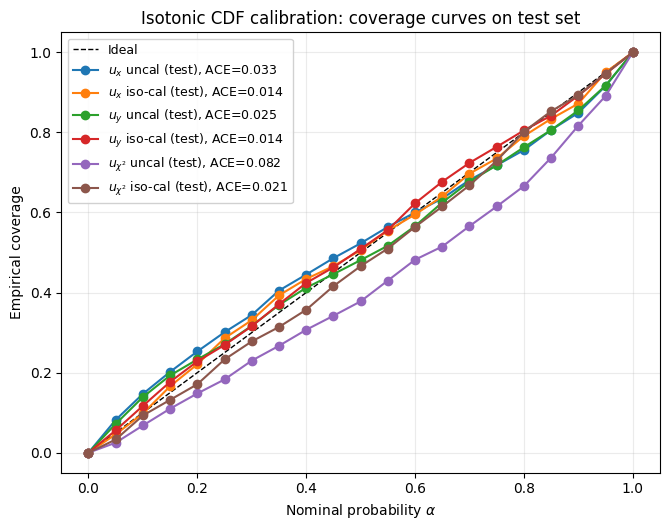

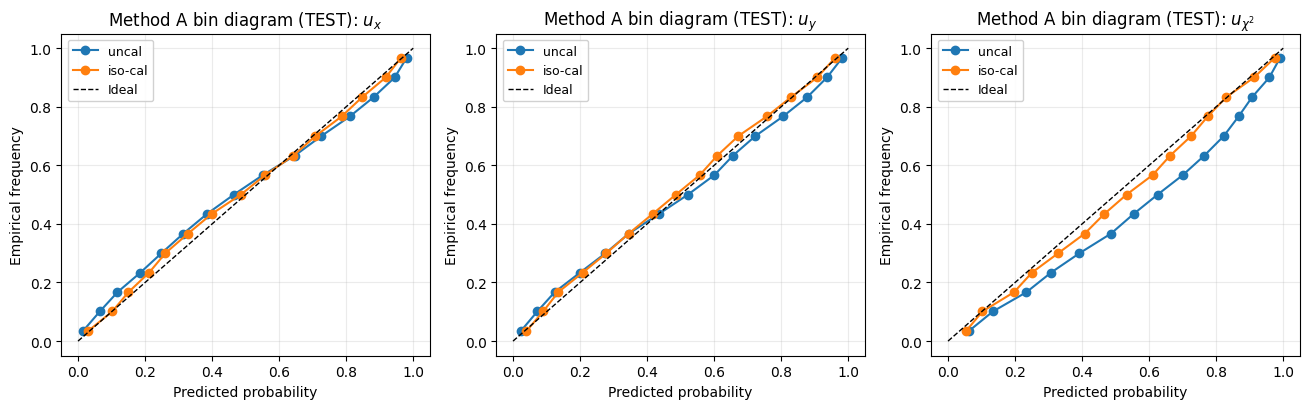

In [8]:
# ==================================================
# Calibration on synthetic data (A vs B, per-axis)
# ==================================================

## IMPORTANT NOTE (evaluation protocol)
# Isotonic CDF calibration (Kuleshov-style) can look "too perfect" if you fit R on a dataset
# and evaluate coverage on the SAME samples: you are essentially fitting an empirical CDF and
# then re-checking it in-sample, which drives ACE toward O(1/N).
#
# To avoid that illusion, we split df_syn into:
#   - calib split: fit the isotonic map R
#   - test split : evaluate coverage curves / ACE (out-of-sample)
#
# Mapping to papers / known methods:
#   Method A' (isotonic CDF calibration) follows Kuleshov et al.: Accurate Uncertainties for Deep Learning Using Calibrated Regression
#     for regression predictive CDF / PIT so that P(U<=alpha)=alpha on held-out data.
#   Method B (binning) is a simple nonparametric map from sigma -> sigma' via per-bin scaling.

from sklearn.model_selection import train_test_split
seed = 42

def split_calib_test(df_in: pd.DataFrame, test_size: float = 0.5, seed: int = 0):
    """Return two disjoint splits: (df_calib, df_test)."""
    if len(df_in) < 50:
        raise ValueError("Dataset too small for calibration/test split.")
    idx = np.arange(len(df_in))
    idx_calib, idx_test = train_test_split(
        idx, test_size=test_size, random_state=seed, shuffle=True
    )
    return df_in.iloc[idx_calib].reset_index(drop=True), df_in.iloc[idx_test].reset_index(drop=True)

def fit_iso_and_eval_coverage(df_calib: pd.DataFrame, df_test: pd.DataFrame, alphas: np.ndarray):
    """Fit isotonic maps on df_calib and evaluate coverage on df_test (plus show in-sample for reference)."""
    out = {}
    # --- x axis ---
    if "std_x" in df_calib.columns:
        u_cal_x = u_gaussian_1d(df_calib["error_x"].to_numpy(), df_calib["std_x"].to_numpy())
        iso_x, _, _ = fit_isotonic_map(u_cal_x)
        u_tst_x = u_gaussian_1d(df_test["error_x"].to_numpy(), df_test["std_x"].to_numpy())
        out["x_uncal_test"] = coverage_curve_uncalibrated_u(u_tst_x, alphas)
        out["x_iso_test"] = coverage_curve_calibrated_u(iso_x, u_tst_x, alphas)
        # in-sample reference (not for claims)
        out["x_uncal_calib"] = coverage_curve_uncalibrated_u(u_cal_x, alphas)
        out["x_iso_calib"] = coverage_curve_calibrated_u(iso_x, u_cal_x, alphas)
        out["iso_x"] = iso_x
        out["u_tst_x"] = u_tst_x
    # --- y axis ---
    if "std_y" in df_calib.columns:
        u_cal_y = u_gaussian_1d(df_calib["error_y"].to_numpy(), df_calib["std_y"].to_numpy())
        iso_y, _, _ = fit_isotonic_map(u_cal_y)
        u_tst_y = u_gaussian_1d(df_test["error_y"].to_numpy(), df_test["std_y"].to_numpy())
        out["y_uncal_test"] = coverage_curve_uncalibrated_u(u_tst_y, alphas)
        out["y_iso_test"] = coverage_curve_calibrated_u(iso_y, u_tst_y, alphas)
        out["y_uncal_calib"] = coverage_curve_uncalibrated_u(u_cal_y, alphas)
        out["y_iso_calib"] = coverage_curve_calibrated_u(iso_y, u_cal_y, alphas)
        out["iso_y"] = iso_y
        out["u_tst_y"] = u_tst_y
    # --- ellipse (chi2 PIT) ---
    if "std_x" in df_calib.columns and "std_y" in df_calib.columns:
        u_cal_e = u_chi2_ellipse(
            df_calib["error_x"].to_numpy(), df_calib["error_y"].to_numpy(),
            df_calib["std_x"].to_numpy(), df_calib["std_y"].to_numpy(),
        )
        iso_e, _, _ = fit_isotonic_map(u_cal_e)
        u_tst_e = u_chi2_ellipse(
            df_test["error_x"].to_numpy(), df_test["error_y"].to_numpy(),
            df_test["std_x"].to_numpy(), df_test["std_y"].to_numpy(),
        )
        out["e_uncal_test"] = coverage_curve_uncalibrated_u(u_tst_e, alphas)
        out["e_iso_test"] = coverage_curve_calibrated_u(iso_e, u_tst_e, alphas)
        out["e_uncal_calib"] = coverage_curve_uncalibrated_u(u_cal_e, alphas)
        out["e_iso_calib"] = coverage_curve_calibrated_u(iso_e, u_cal_e, alphas)
        out["iso_e"] = iso_e
        out["u_tst_e"] = u_tst_e
    return out

def _binned_reliability_u(u: np.ndarray, iso, n_bins: int = 15, min_count: int = 25):
    """Method A bin图：x=predicted prob (bin median u), y=empirical freq (mean 1{u<=alpha}).

    - For uncal: alpha = u (identity)
    - For iso-cal: alpha = R(u)

    Returned DataFrame columns: bin, n, u_med, emp, pred_uncal, pred_iso
    """
    u = np.asarray(u)
    u = u[np.isfinite(u)]
    u = np.clip(u, 0.0, 1.0)
    if len(u) < max(50, min_count):
        raise ValueError("Not enough samples for binned reliability.")
    edges = make_bins_equal_count(u, n_bins)
    idx = np.digitize(u, edges, right=False) - 1
    idx = np.clip(idx, 0, n_bins - 1)
    pred_iso = iso.predict(u)
    out = []
    for b in range(n_bins):
        m = idx == b
        if m.sum() < min_count:
            continue
        u_med = float(np.median(u[m]))
        emp = float((u <= u_med).mean())
        out.append((b, int(m.sum()), u_med, emp, u_med, float(np.median(pred_iso[m]))))
    return pd.DataFrame(out, columns=["bin", "n", "u_med", "emp", "pred_uncal", "pred_iso"])

# ----------------- Run split evaluation -----------------
alphas_plot = np.linspace(0, 1, 21)
df_calib, df_test = split_calib_test(df_syn, test_size=0.5, seed=seed)
print("Split sizes:", "calib=", len(df_calib), ", test=", len(df_test))

iso_eval = fit_iso_and_eval_coverage(df_calib, df_test, alphas_plot)

def _print_cov_table(title: str, alphas: np.ndarray, uncal: np.ndarray, iso: np.ndarray):
    df_cov = pd.DataFrame({
        "alpha": alphas,
        "uncal": np.asarray(uncal),
        "iso": np.asarray(iso),
        "abs_err_uncal": np.abs(np.asarray(uncal) - alphas),
        "abs_err_iso": np.abs(np.asarray(iso) - alphas),
    })
    print(f"\nCoverage ({title}):")
    print(df_cov.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    print(f"ACE uncal: {ace_metric(alphas, uncal):.4f}, ACE iso: {ace_metric(alphas, iso):.4f}")

# Print test-set coverage tables (this is what you should report)
if "x_uncal_test" in iso_eval:
    _print_cov_table("x (TEST)", alphas_plot, iso_eval["x_uncal_test"], iso_eval["x_iso_test"])
if "y_uncal_test" in iso_eval:
    _print_cov_table("y (TEST)", alphas_plot, iso_eval["y_uncal_test"], iso_eval["y_iso_test"])
if "e_uncal_test" in iso_eval:
    _print_cov_table("ellipse (TEST)", alphas_plot, iso_eval["e_uncal_test"], iso_eval["e_iso_test"])

print("\nPaper-style summary (TEST):")
if "x_uncal_test" in iso_eval:
    print("[A' iso] x  : ACE uncal=%.3f, ACE iso=%.3f" % (ace_metric(alphas_plot, iso_eval["x_uncal_test"]), ace_metric(alphas_plot, iso_eval["x_iso_test"])))
if "y_uncal_test" in iso_eval:
    print("[A' iso] y  : ACE uncal=%.3f, ACE iso=%.3f" % (ace_metric(alphas_plot, iso_eval["y_uncal_test"]), ace_metric(alphas_plot, iso_eval["y_iso_test"])))
if "e_uncal_test" in iso_eval:
    print("[A' iso] ell: ACE uncal=%.3f, ACE iso=%.3f" % (ace_metric(alphas_plot, iso_eval["e_uncal_test"]), ace_metric(alphas_plot, iso_eval["e_iso_test"])))

# --- Coverage curve figure: TEST-set curves (plus optional in-sample reference dashed)
plt.figure(figsize=(6.8, 5.4))
plt.plot(alphas_plot, alphas_plot, "k--", lw=1, label="Ideal")

# Test curves (solid)
if "x_uncal_test" in iso_eval:
    plt.plot(alphas_plot, iso_eval["x_uncal_test"], "o-", label=rf"$u_x$ uncal (test), ACE={ace_metric(alphas_plot, iso_eval['x_uncal_test']):.3f}")
    plt.plot(alphas_plot, iso_eval["x_iso_test"], "o-", label=rf"$u_x$ iso-cal (test), ACE={ace_metric(alphas_plot, iso_eval['x_iso_test']):.3f}")
if "y_uncal_test" in iso_eval:
    plt.plot(alphas_plot, iso_eval["y_uncal_test"], "o-", label=rf"$u_y$ uncal (test), ACE={ace_metric(alphas_plot, iso_eval['y_uncal_test']):.3f}")
    plt.plot(alphas_plot, iso_eval["y_iso_test"], "o-", label=rf"$u_y$ iso-cal (test), ACE={ace_metric(alphas_plot, iso_eval['y_iso_test']):.3f}")
if "e_uncal_test" in iso_eval:
    plt.plot(alphas_plot, iso_eval["e_uncal_test"], "o-", label=rf"$u_{{\chi^2}}$ uncal (test), ACE={ace_metric(alphas_plot, iso_eval['e_uncal_test']):.3f}")
    plt.plot(alphas_plot, iso_eval["e_iso_test"], "o-", label=rf"$u_{{\chi^2}}$ iso-cal (test), ACE={ace_metric(alphas_plot, iso_eval['e_iso_test']):.3f}")

plt.xlabel(r"Nominal probability $\alpha$")
plt.ylabel("Empirical coverage")
plt.title(r"Isotonic CDF calibration: coverage curves on test set")
plt.grid(True, alpha=0.25)
plt.legend(fontsize=9, frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()

# --- NEW: Method A binned reliability diagram (TEST split)
# This is analogous to Method B's bin plot, but for PIT u (probability-scale reliability).
# x-axis: predicted probability (uncal: u, iso: R(u))
# y-axis: empirical frequency (computed from test samples)
n_bins_A = 15
min_count_A = 25

fig, ax = plt.subplots(1, 3, figsize=(13.2, 4.2))
panels = [
    ("x", "u_tst_x", "iso_x", r"$u_x$"),
    ("y", "u_tst_y", "iso_y", r"$u_y$"),
    ("ellipse", "u_tst_e", "iso_e", r"$u_{\chi^2}$"),
 ]

for j, (key, u_key, iso_key, title_u) in enumerate(panels):
    if u_key not in iso_eval or iso_key not in iso_eval:
        ax[j].axis("off")
        continue
    bdf = _binned_reliability_u(iso_eval[u_key], iso_eval[iso_key], n_bins=n_bins_A, min_count=min_count_A)
    ax[j].plot(bdf["pred_uncal"], bdf["emp"], "o-", label="uncal")
    ax[j].plot(bdf["pred_iso"], bdf["emp"], "o-", label="iso-cal")
    ax[j].plot([0, 1], [0, 1], "k--", lw=1, label="Ideal")
    ax[j].set_xlabel("Predicted probability")
    ax[j].set_ylabel("Empirical frequency")
    ax[j].set_title(f"Method A bin diagram (TEST): {title_u}")
    ax[j].grid(True, alpha=0.25)
    ax[j].legend(fontsize=9, frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

[B+B] bins edges_x: [0.037 0.066 0.074 0.082 0.088 0.098 0.106 0.116 0.131 0.147 0.169 0.208
 0.367]
[B+B] per-bin scale_x: [0.87569578 1.09072359 0.99660693 1.4        1.24930389 1.27561109
 1.23163819 1.18325821 1.33187366 1.18758988 1.17080849 1.21989502]
[B+B] bins edges_y: [0.02       0.045      0.052      0.059      0.064      0.069
 0.074      0.083      0.092      0.103      0.11683333 0.141
 0.281     ]
[B+B] per-bin scale_y: [0.92384493 0.94031998 1.08583128 1.14716515 1.09970746 1.13247479
 1.27241493 1.11055013 1.3572286  1.13761995 1.24961561 1.27491117]
B+B binned reliability (alpha=0.683)
|e_x| biased | relative gap: 0.2107259603618506
|e_x| B-cal  | relative gap: 0.051243784573893676
|e_y| biased | relative gap: 0.1910450336517769
|e_y| B-cal  | relative gap: 0.06883719432896943
σ_xy biased  | relative gap: 0.16025348957537433
σ_xy B-cal   | relative gap: 0.05699490463420199


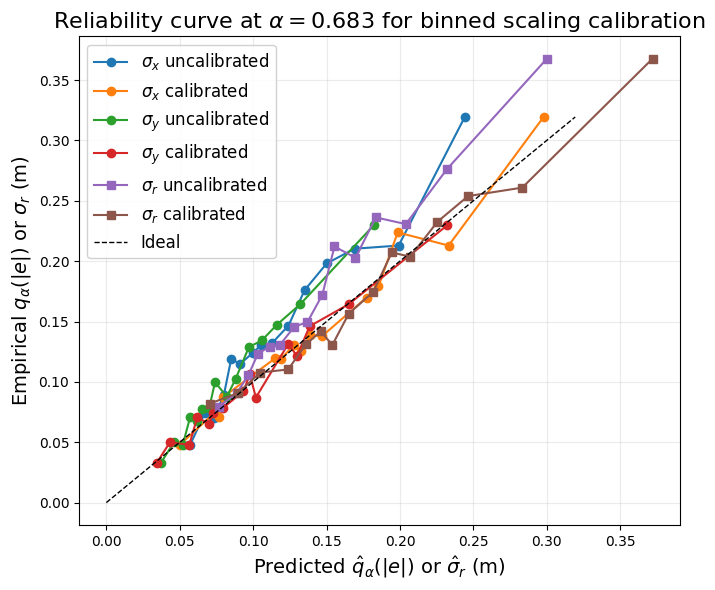

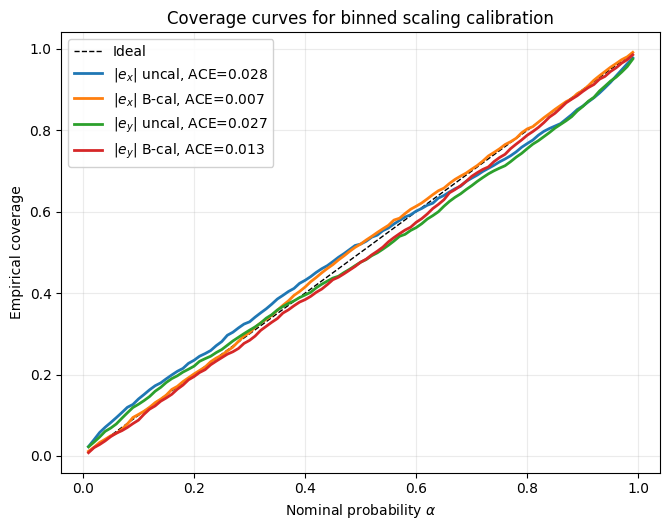

In [10]:
# ========================================================
# Evaluation Method B (refactored: reuse earlier helpers)
# ========================================================

from typing import Tuple, Optional

# Reuse helper from Method B (cell 5): make_bins_equal_count(values, n_bins)
# Reuse stats from scipy already imported in cell 2

def fit_binned_scale_axis(errors: np.ndarray, sigma: np.ndarray, n_bins: int = 12, alpha: float = 0.9, min_count: int = 30):
    """Fit a piecewise-constant scale(sigma) based on binned quantile matching."""
    errors = np.asarray(errors)
    sigma = np.asarray(sigma)
    values_for_binning = sigma
    valid = (sigma > 0)
    e, s, v = np.abs(errors[valid]), sigma[valid], values_for_binning[valid]
    edges = make_bins_equal_count(v, n_bins)
    idx = np.digitize(v, edges, right=False) - 1
    idx = np.clip(idx, 0, n_bins - 1)
    scale = np.ones(n_bins, dtype=float)
    for b in range(n_bins):
        m = idx == b
        if m.sum() < min_count:
            continue
        s_med = np.median(s[m])
        q_emp = np.quantile(e[m], alpha)
        q_pred = stats.halfnorm.ppf(alpha, scale=s_med)
        scale[b] = float(q_emp / (q_pred + 1e-12))
    lo, hi = (0.6, 1.4)
    scale = np.clip(scale, lo, hi)
    return edges, scale

def apply_binned_scale(sigma: np.ndarray, edges: np.ndarray, scale: np.ndarray) -> np.ndarray:
    s = np.asarray(sigma)
    idx = np.digitize(s, edges, right=False) - 1
    idx = np.clip(idx, 0, len(scale) - 1)
    return s * scale[idx]

# -----------------------------
# Run Method B calibration + evaluation on synthetic data
# -----------------------------
n_bins_eval = 15
alpha_bin_eval = 0.683
alpha_fit = 0.683

n_bins_cal = 12
edges_x, scale_x = fit_binned_scale_axis( df_syn["error_x"].to_numpy(), df_syn["std_x"].to_numpy(), n_bins=n_bins_cal, alpha=alpha_fit)
edges_y, scale_y = fit_binned_scale_axis( df_syn["error_y"].to_numpy(), df_syn["std_y"].to_numpy(), n_bins=n_bins_cal, alpha=alpha_fit)

df_syn["std_x_B"] = apply_binned_scale(df_syn["std_x"].to_numpy(), edges_x, scale_x)
df_syn["std_y_B"] = apply_binned_scale(df_syn["std_y"].to_numpy(), edges_y, scale_y)
df_syn["std_xy_B"] = np.sqrt(df_syn["std_x_B"]**2 + df_syn["std_y_B"]**2)

print(f"[B+B] bins edges_x:", edges_x)
print("[B+B] per-bin scale_x:", scale_x)
print(f"[B+B] bins edges_y:", edges_y)
print("[B+B] per-bin scale_y:", scale_y)

base_std_x = df_syn["std_x"].to_numpy()
base_std_y = df_syn["std_y"].to_numpy()

bx_biased = binned_reliability_1d( df_syn["error_x"].to_numpy(), base_std_x, n_bins=n_bins_eval, alpha=alpha_bin_eval)
by_biased = binned_reliability_1d( df_syn["error_y"].to_numpy(), base_std_y, n_bins=n_bins_eval, alpha=alpha_bin_eval)
bxy_b = binned_empirical_std_r( df_syn["error_x"].to_numpy(), df_syn["error_y"].to_numpy(), base_std_x, base_std_y, n_bins=n_bins_eval, min_count=25)

bx_B = binned_reliability_1d(df_syn["error_x"].to_numpy(), df_syn["std_x_B"].to_numpy(), n_bins=n_bins_eval, alpha=alpha_bin_eval)
by_B = binned_reliability_1d(df_syn["error_y"].to_numpy(), df_syn["std_y_B"].to_numpy(), n_bins=n_bins_eval, alpha=alpha_bin_eval)
bxy_B = binned_empirical_std_r(df_syn["error_x"].to_numpy(), df_syn["error_y"].to_numpy(), df_syn["std_x_B"].to_numpy(), df_syn["std_y_B"].to_numpy(), n_bins=n_bins_eval, min_count=25)

print(f"B+B binned reliability (alpha={alpha_bin_eval})")
print("|e_x| biased | relative gap:", summarize_rel_gap(bx_biased))
print("|e_x| B-cal  | relative gap:", summarize_rel_gap(bx_B))
print("|e_y| biased | relative gap:", summarize_rel_gap(by_biased))
print("|e_y| B-cal  | relative gap:", summarize_rel_gap(by_B))
print("σ_xy biased  | relative gap:", summarize_rel_gap(bxy_b))
print("σ_xy B-cal   | relative gap:", summarize_rel_gap(bxy_B))
plt.figure(figsize=(7.0, 6.0))
plt.plot(bx_biased["pred_q"], bx_biased["emp_q"], "o-", label=rf"$\sigma_x$ uncalibrated")
plt.plot(bx_B["pred_q"], bx_B["emp_q"], "o-", label=rf"$\sigma_x$ calibrated")
plt.plot(by_biased["pred_q"], by_biased["emp_q"], "o-", label=rf"$\sigma_y$ uncalibrated")
plt.plot(by_B["pred_q"], by_B["emp_q"], "o-", label=rf"$\sigma_y$ calibrated")
plt.plot(bxy_b["pred_q"], bxy_b["emp_q"], "s-", lw=1.5, label=rf"$\sigma_{{r}}$ uncalibrated")
plt.plot(bxy_B["pred_q"], bxy_B["emp_q"], "s-", lw=1.5, label=rf"$\sigma_{{r}}$ calibrated")

mx = max([d[["pred_q", "emp_q"]].to_numpy().max() for d in [bx_biased, bx_B, by_biased, by_B]])

plt.plot([0, mx], [0, mx], "k--", lw=1, label="Ideal")

plt.xlabel(r"Predicted $\hat{q}_{\alpha}(|e|)$ or $\hat{\sigma}_{r}$ (m)", fontsize=14)
plt.ylabel(r"Empirical $q_{\alpha}(|e|)$ or $\sigma_{r}$ (m)", fontsize=14)
plt.title(rf"Reliability curve at $\alpha={alpha_bin_eval}$ for binned scaling calibration", fontsize=16)
plt.grid(True, alpha=0.25)
plt.legend(fontsize=12, frameon=True, framealpha=0.9)
plt.tight_layout()
plt.savefig("binned_scaling_calibration_reliability.png", dpi=300)
plt.show()

# # NEW: Reliability / coverage curves for Method B (coverage vs alpha)
alphas_curve = np.linspace(0.01, 0.99, 99)
cov_x_uncal = coverage_curve_1d(df_syn["error_x"].to_numpy(), df_syn["std_x"].to_numpy(), alphas_curve)
cov_x_B = coverage_curve_1d(df_syn["error_x"].to_numpy(), df_syn["std_x_B"].to_numpy(), alphas_curve)
cov_y_uncal = coverage_curve_1d(df_syn["error_y"].to_numpy(), df_syn["std_y"].to_numpy(), alphas_curve)
cov_y_B = coverage_curve_1d(df_syn["error_y"].to_numpy(), df_syn["std_y_B"].to_numpy(), alphas_curve)

plt.figure(figsize=(6.8, 5.4))
plt.plot(alphas_curve, alphas_curve, "k--", lw=1, label="Ideal")
plt.plot(alphas_curve, cov_x_uncal, lw=2.0, label=rf"$|e_x|$ uncal, ACE={ace_metric(alphas_curve, cov_x_uncal):.3f}")
plt.plot(alphas_curve, cov_x_B, lw=2.0, label=rf"$|e_x|$ B-cal, ACE={ace_metric(alphas_curve, cov_x_B):.3f}")
plt.plot(alphas_curve, cov_y_uncal, lw=2.0, label=rf"$|e_y|$ uncal, ACE={ace_metric(alphas_curve, cov_y_uncal):.3f}")
plt.plot(alphas_curve, cov_y_B, lw=2.0, label=rf"$|e_y|$ B-cal, ACE={ace_metric(alphas_curve, cov_y_B):.3f}")
plt.xlabel(r"Nominal probability $\alpha$")
plt.ylabel("Empirical coverage")
plt.title(r"Coverage curves for binned scaling calibration")
plt.grid(True, alpha=0.25)
plt.legend(fontsize=10, frameon=True, framealpha=0.9)
plt.tight_layout()
plt.savefig("coverage_curves_binned_scaling_calibration.png", dpi=300)
plt.show()